In [1]:
from matipo import SEQUENCE_DIR, GLOBALS_DIR
from matipo.sequence import Sequence
from matipo.util.autophase import autophase
import numpy as np
import matplotlib.pyplot as plt

# set matplotlib figure size, default is quite small
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100

# function for calculating T2 from a CPMG curve
from scipy.interpolate import interp1d
def calc_CPMG_T2(t, y):
    # T2 decay theoretical magnetization is given by M_xy(t) = M_xy(0)*e^(-t/T2)
    # so M_xy(T2)/M_xy(0) = e^-1
    invf = interp1d(y/y[0], t)
    return invf(np.exp(-1))

# progress_handler for Sequence.run() that simply prints the progress
def print_progress(p, l):
    print(p, '/', l)

# load CPMG pulse sequence
seq = Sequence(SEQUENCE_DIR+'CPMG.py')

In [2]:
# load relevant global variables
seq.loadpar(GLOBALS_DIR+'frequency.yaml')
seq.loadpar(GLOBALS_DIR+'hardpulse_90.yaml')
seq.loadpar(GLOBALS_DIR+'hardpulse_180.yaml')

# set some parameters directly (SI units)
seq.setpar(
    n_scans=2,
    n_echo=2000,
    t_echo=500e-6,
    n_samples=64,
    t_dw=1e-6,
    t_end=1)

# print out the parameter set for reference
print(seq.par)

# run sequence, progress_handler is optional
y = await seq.run(progress_handler=print_progress)

ParameterSet(n_scans=2, f=15089547.419315256, a_90=0.34987021061682183, t_90=3.2e-05, a_180=0.7263180024450473, t_180=3.2e-05, t_echo=0.0005, n_echo=2000, t_dw=1e-06, n_samples=64, t_end=1.0)
1 / 2
2 / 2


T2 = 0.1830 seconds


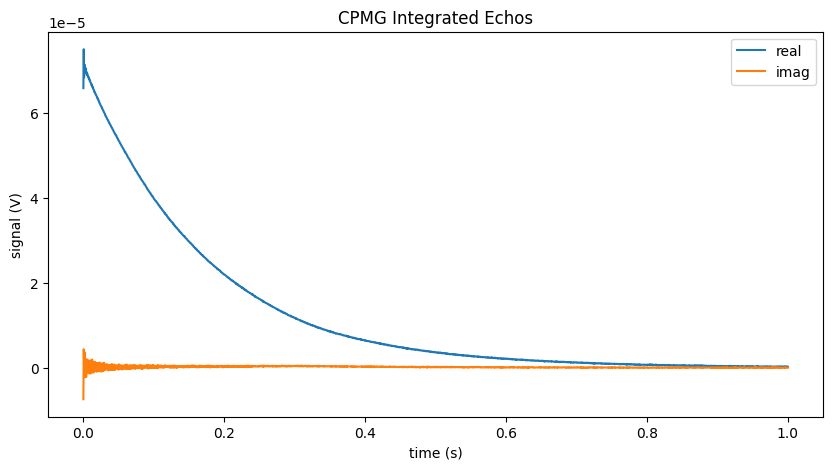

In [3]:
# average the echos to get the integrated echo decay curve
y_int = np.mean(np.reshape(y, (-1, seq.par.n_samples)), axis=1)
y_int = autophase(y_int)
t_int = np.linspace(0, seq.par.n_echo*seq.par.t_echo, seq.par.n_echo)

try:
    # use magnitude to calculate T2
    T2 = calc_CPMG_T2(t_int, np.abs(y_int))
    print(f'T2 = {T2:.4f} seconds')
except:
    print('Could not calculate T2')

plt.plot(t_int, y_int.real, label='real')
plt.plot(t_int, y_int.imag, label='imag')
plt.ylabel('signal (V)')
plt.xlabel('time (s)')
plt.title('CPMG Integrated Echos')
plt.legend()
plt.show()